In [1]:
import numpy as np

def load_mdp(file_str, gamma):
    
    gamma = np.clip(gamma, 0, 1)
    
    data = np.load(file_str)
    
    M = []
    
    for k in data.keys():
        M.append(data[k])
        
    M.append(gamma)
    
    M = tuple(M)
        
    return M

M = load_mdp('pacman.npz', 0.9)

In [2]:
def generate_transition(M, policy, state, action_list, state_list):
        
        action_prob = policy[state,:]
        
        if action_list.size > 1:
            action = np.random.choice(action_list, p = action_prob)
        else:
            action = action_list

        new_state = np.random.choice(state_list, p = M[2][action][state,:])
        
        cost = M[3][state][action]
        
        transition = (state, action, cost, new_state)
        
        return transition

In [3]:
def generate_episode(M, policy, length):
    
    action_list = np.arange(len(M[1]), dtype=int)

    state_list = np.arange(len(M[0]), dtype=int)
    
    epsilon = []
    
    state = np.random.choice(state_list)
    
    flag = False
    
    for i in range(length):

        transition = generate_transition(M, policy, state, action_list, state_list)
        
        epsilon.append(transition)
        
        state = transition[-1]
        
        if flag == True:
            break
        
        if state == state_list[-1] or state == state_list[-2]:
            flag = True
        
    return epsilon

In [4]:
N = 10000

In [5]:
def Q_learning(M, step, gamma, T):
    
    action_list = np.arange(len(M[1]), dtype=int)

    state_list = np.arange(np.shape(M[0])[0], dtype=int)
    
    Q = np.zeros([len(M[0]), len(M[1])])
    Q_old = np.ones(Q.shape)
    
    k = 0
    
    policy = np.ones(Q.shape)/len(M[1])
    
    Q_list = []
    
    Q_iter = np.zeros([len(M[0]), len(M[1])])
    
    while k < N:
        
        Q_old = Q
        
        k+=1
        
        epsilon = generate_episode(M, policy, T)
        
        for t in range(0, len(epsilon)):
            
            x = epsilon[t][0]
            a = epsilon[t][1]
            c = epsilon[t][2]
            xplus = epsilon[t][3]
            
            delta = c + gamma*np.min(Q[xplus,:])-Q[x,a]
            
            Q[x,a] += step*delta

        Q_list.append(np.copy(Q))
            
    return [Q, Q_list]

In [6]:
[Q_Q_learning, Q_list_Q_learning] = Q_learning(M, 0.1, 0.9, 209)

In [7]:
def policy_iteration(M):
    
    P = M[2]
    c = M[3]
    gamma = M[4]
    
    c = np.reshape(c.T, [c.shape[1],c.shape[0],1])
    
    pi = np.ones(c.shape)/c.shape[0]
    pi_prev = np.ones(c.shape)
    
    k = 0
    
    while not np.allclose(pi,pi_prev):
        
        pi_prev = pi
        
        P_pi = np.sum(P*pi, axis = 0)
        c_pi = np.sum(c*pi, axis = 0)
        
        J = np.matmul(np.linalg.inv(np.eye(P_pi.shape[0]) - gamma*P_pi), c_pi)
        
        Q = c + gamma * np.matmul(P,J)
        
        pi = np.isclose(Q, np.min(Q,axis = 0), atol = 1e-8, rtol = 1e-8).astype(int)

        pi = pi/np.sum(pi, axis = 0)
        
        k += 1
        
    pi = np.concatenate(pi, axis = 1)
    
    Q = np.concatenate(Q, axis = 1)
    
    return [Q, pi]

[Q, pi_star] = policy_iteration(M)

In [8]:
def epsilon_greedy(M, Q, u, kt):
    
    epsilon = u*kt**-1
    
    epsilon = np.reshape(epsilon, [Q.shape[0],1])

    action_list = np.arange(len(M[1]), dtype=int)

    state_list = np.arange(np.shape(M[0])[0], dtype=int)
    
    policy = np.ones([len(state_list), len(action_list)])*epsilon/len(action_list)
    
    a_mins = np.argmin(Q, axis = 1)
    
    indexes = np.arange(0, policy.shape[0]*policy.shape[1], policy.shape[1]) + a_mins
    
    np.put(policy, indexes, 1-epsilon+epsilon/len(action_list))
    
    return policy

In [9]:
def boltzmann(M, Q, u, kt):
    
    Qmin = np.reshape(np.min(Q, axis = 1), [Q.shape[0], 1])
    
    u = np.max(np.abs(Q-Qmin), axis = 1)
    
    eta = np.log(kt)/u
    
    eta = np.reshape(eta, [eta.size, 1])
    
    eta = np.nan_to_num(eta)
    
    f = np.reshape(np.max(eta*Q, axis = 1), [Q.shape[0],1])
    
    F = np.sum(np.exp(eta*Q - f), axis = 1)

    F = np.reshape(F, [F.size,1])

    policy = np.exp(eta*Q - f)/F
    
    return policy

In [10]:
def SARSA(M, step, gamma, T, policy_function):
    
    action_list = np.arange(len(M[1]), dtype=int)

    state_list = np.arange(np.shape(M[0])[0], dtype=int)
    
    Q = np.zeros([len(M[0]), len(M[1])])
    Q_old = np.ones(Q.shape)
    
    k = 0
    
    Q_list = []
    
    while k < N:
        
        k+=1
        
        kt = np.zeros(len(state_list))
        
        x0 = np.random.choice(state_list)
        
        kt[x0] +=1
        
        u = 0.5
        
        policy = policy_function(M,Q,u,kt)
            
        transition = generate_transition(M, policy, x0, action_list, state_list)
            
        x = transition[0]
        a = transition[1]
        c = transition[2]
        xplus = transition[3]
        
        kt[x] +=1
        kt[xplus] +=1
        
        policy = policy_function(M,Q,u,kt)
        
        transition = generate_transition(M, policy, xplus, action_list, state_list)
        
        aplus = transition[1]
        
        delta = c + gamma*Q[xplus,aplus]-Q[x,a]
            
        Q[x,a] += step*delta
        
        for t in range(0, T-1):
            
            transition = generate_transition(M, policy, xplus, aplus, state_list)
            
            x = transition[0]
            a = transition[1]
            c = transition[2]
            xplus = transition[3]
            
            kt[xplus] +=1
            
            policy = policy_function(M,Q,u,kt)
            
            transition = generate_transition(M, policy, xplus, action_list, state_list)
        
            aplus = transition[1]

            delta = c + gamma*Q[xplus,aplus]-Q[x,a]
            
            Q[x,a] += step*delta
            
            if x == state_list[-1] or x == state_list[-2]:
                break
                
        Q_list.append(np.copy(Q))
            
    return [Q, Q_list]

In [11]:
[Q_SARSA, Q_list_SARSA] = SARSA(M, 0.5, 0.9, 209, epsilon_greedy)

/tmp/ipykernel_7637/1241646542.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  epsilon = u*kt**-1
/tmp/ipykernel_7637/1241646542.py:17: RuntimeWarning: invalid value encountered in add
  np.put(policy, indexes, 1-epsilon+epsilon/len(action_list))


In [12]:
def ARTDP_prediction(M, policy, gamma, step):
    
    A = np.arange(len(M[1]), dtype=int)
    X = np.arange(len(M[0]), dtype=int)
    
    P = np.eye(len(X))
    c = np.zeros([len(X), 1])
    J = np.zeros([len(X), 1])
    k = np.zeros([len(X), 1])
    
    while np.max(k) < N:
        epsilon = generate_episode(M, policy, 209)
        Xt = []
        
        for tau in epsilon:
            xt = tau[0]
            ct = tau[-2]
            xtplus = tau[-1]
            k[xt] += 1
            Xt.append(xt)
            
            for y in X:
                P[xt, y] += step*(int(xtplus == y) - P[xt, y])
                
            c[xt] += step*(ct - c[xt])
            
            for x in Xt:
                J[x] = c[x] + gamma * P[x,:]@J
            
    return J

In [13]:
J = ARTDP_prediction(M, pi_star, 0.9, 0.1)

In [14]:
i = np.where(M[0] == '(28, 0, 3)')

In [15]:
J[i]

array([[0.67088647]])

In [16]:
def ARTDP_prediction(M, policy, gamma, step):
    
    A = np.arange(len(M[1]), dtype=int)
    X = np.arange(len(M[0]), dtype=int)
    
    P = np.eye(len(X))
    c = np.zeros([len(X), 1])
    J = np.zeros([len(X), 1])
    k = np.zeros([len(X), 1])
    
    while np.max(k) < N:
        epsilon = generate_episode(M, policy, 209)
        Xt = []
        
        for tau in epsilon:
            xt = tau[0]
            ct = tau[-2]
            xtplus = tau[-1]
            k[xt] += 1
            Xt.append(xt)
            
            for y in X:
                P[xt, y] += step*(int(xtplus == y) - P[xt, y])
                
            c[xt] += step*(ct - c[xt])
            
            for x in Xt:
                J[x] = c[x] + gamma * P[x,:]@J
            
    return J

In [17]:
def ARTDP_control(M, policy, gamma, step):
    
    A = np.arange(len(M[1]), dtype=int)
    X = np.arange(len(M[0]), dtype=int)
    
    P = []
    c = []
    
    for a in A:
        P.append(np.eye(len(X)))
        c.append(np.zeros([len(X), 1]))
        
    P = np.array(P)
    c = np.array(c)

    k = 0
    
    Q = np.zeros([len(X),len(A)])
    Q_list = []
    
    while k < N:
        epsilon = generate_episode(M, policy, 209)
        Xt = []
        k +=1
        
        for tau in epsilon:
            xt = tau[0]
            at = tau[1]
            ct = tau[-2]
            xtplus = tau[-1]
            Xt.append(xt)
            
            for y in X:
                P[at][xt, y] += step*(int(xtplus == y) - P[at][xt, y])
                
            c[at][xt] += step*(ct - c[at][xt])
                
        Qmin = np.reshape(np.min(Q, axis = 1), [len(X),1])

        Q = c + gamma * np.matmul(P,Qmin)
        Q = np.concatenate(Q, axis = 1)
        Q_list.append(np.copy(Q))
        
    return [Q, Q_list]

In [18]:
[Q_Model, Q_list_Model] = ARTDP_control(M, np.ones(Q.shape)/4, 0.9, 0.1)

In [19]:
np.linalg.norm(Q_Model-Q, 'fro')

0.13725001264296655

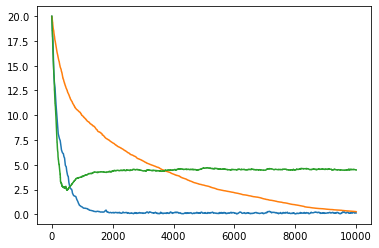

In [20]:
import matplotlib.pyplot as plt

y_Q_Learning = []
y_SARSA = []
y_Model = []

for Q_iter in Q_list_Model:
    y_Model.append(np.linalg.norm(Q_iter-Q, 'fro'))
    
for Q_iter in Q_list_Q_learning:
    y_Q_Learning.append(np.linalg.norm(Q_iter-Q, 'fro'))
    
for Q_iter in Q_list_SARSA:
    y_SARSA.append(np.linalg.norm(Q_iter-Q, 'fro'))
    
x = np.arange(len(y_Model))    

plt.plot(x,y_Model)
plt.plot(x,y_Q_Learning)
plt.plot(x,y_SARSA)